# COP508 Machine Learning CW

Table of Contents:

## Data Ingestion

### Importing the libraries

In [2]:
import os
import numpy as np
import pickle
import requests
import matplotlib.pyplot as plt
import cv2
import wget
import tensorflow as tf
from skimage.util import random_noise
from sklearn.metrics import accuracy_score
from matplotlib import image
from scipy import ndimage
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras import optimizers
from keras.models import Sequential

### Importing the dataset from local machine

In [3]:
path_to_check = os.path.join('', 'image_recognition_dataset.pth')
data_path = path_to_check
def load_coursework_data():
    if not os.path.exists(path_to_check):
        print("Cannot find the dataset on local !")
        print("Downloading the dataset from cloud, it may take several mintues.")
        url = 'https://www.dropbox.com/s/j05hyf667ikzu4s/image_recognition_dataset.pth?dl=1'
        filename = wget.download(url)
        data_path = os.path.join('', filename)
    else:
        print("Data found on local {:s}".format(path_to_check))
        data_path = path_to_check
        
    data = pickle.load(open(data_path, 'rb'))
    train_imgs,train_labels,test_imgs,test_labels = data.values()
    return train_imgs,train_labels,test_imgs,test_labels

### Splitting the dataset into the Training & Test set

In [4]:
train_imgs,train_labels,test_imgs,test_labels = load_coursework_data()

Cannot find the dataset on local !


### Displaying dataset information 

In [5]:
cls_train = len(np.unique(train_labels))
print("Total number of image classes : {:d}".format(cls_train))
print("Shape of training set", train_imgs.shape)
print("Training image count: ", train_imgs.shape[0])
print("Test image count: ", test_imgs.shape[0])

Total number of image classes : 8
Shape of training set (40000, 32, 32, 3)
Training image count:  40000
Test image count:  8000


### Visualising five images from the dataset

/home/lunet/conm/.conda/envs/cop508/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


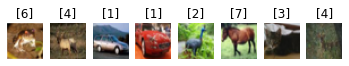

In [6]:
def plot_trained_images() -> None:
    for i in range(8):
        plt.subplot(1, 8, i+1)
        imgData = np.array(train_imgs[i])
        plt.title(train_labels[i])
        plt.imshow(imgData)
        plt.axis('off')
plot_trained_images()

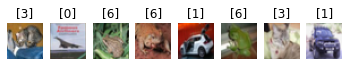

In [7]:
def plot_test_images() -> None:
    for i in range(8):
        plt.subplot(1, 8, i+1)
        imgData = np.array(test_imgs[i])
        plt.title(test_labels[i])
        plt.imshow(imgData)
        plt.axis('off')
plot_test_images()

## Data Preprocessing

### Gray scale conversion

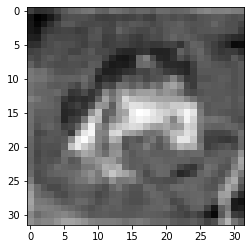

In [8]:
grayscale_train_img = [cv2.cvtColor(one_img, cv2.COLOR_BGR2GRAY) for one_img in train_imgs]
grayscale_test_img = [cv2.cvtColor(one_img, cv2.COLOR_BGR2GRAY) for one_img in test_imgs]
plt.imshow(grayscale_train_img[0], cmap='gray')

### Normalization

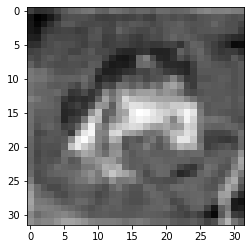

In [9]:
normalized_train_img = [one_img/255.0 for one_img in train_imgs]
normalized_test_img =  [one_img/255.0 for one_img in test_imgs]
plt.imshow(normalized_train_img[0])

### Gaussian Blur

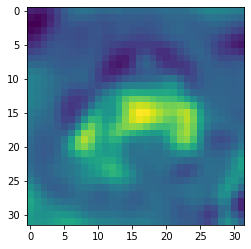

In [10]:
train_blurred_img = [ndimage.gaussian_filter(train_blur_imgs, sigma= 1) for train_blur_imgs in normalized_train_img]
test_blurred_img = [ndimage.gaussian_filter(test_blur_imgs, sigma= 1) for test_blur_imgs in normalized_test_img]
plt.imshow(train_blurred_img[0])

### Rotation

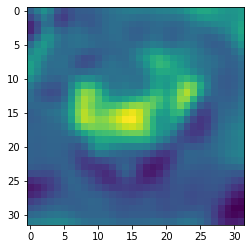

In [11]:
rotated_train_img = np.array([ndimage.rotate(train_rotate_imgs, angle=180) for train_rotate_imgs in normalized_train_img])
rotated_test_img = np.array([ndimage.rotate(test_rotate_imgs, angle=180) for test_rotate_imgs in normalized_test_img])
plt.imshow(rotated_train_img[0])

## Model Selection

## Model Evaluation

## Model Launch/Prediction